# Generalized coordinates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from decimal import Decimal

In [2]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

## Definition
For the linear models of the eye and arm, we consider a single-input single-output discrete-time system under control with the following state-update equation:
$$
\tilde{x}_{t+1} = A\tilde{x}_t+B\left (u_t+w_t \right)
$$  
where $\tilde{x}_t$ is the $n$-dimentional state at time $t$, $\tilde{x}_{t+1}$ is the $n$-dimentional state at time $t+dt$, $u_t$ the neural driving signal at time $t$, $w_t$ is a white noise with mean zero and variance $ku_t^2$, $A$ is a fixed $n \times n$ matrix and B is a $n \times 1$ vector both describing the dynamics of the system.

Here, A will be the following matrix:  

$$ A = 
\begin{bmatrix}
1 & dt & \frac{dt^2}{2} & \cdots & \frac{dt^n}{n!}\\
0 & 1 & dt & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & \vdots\\
0 & 0 & 0 & 1 & dt \\
0 & \cdots & \cdots & \cdots & 1-\frac{dt}{\tau}
\end{bmatrix}
\textbf{ }\textbf{ }\textbf{ }\textbf{ }and\textbf{ }\textbf{ }\textbf{ }\textbf{ }
B = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \\ dt\end{bmatrix}
$$  
  
We choose this matrix since, according to the Taylor's formula:  
$ x\left (t+dt \right) = x\left (t \right) + dt\times \dot{x}\left (t \right) + \frac{dt^2}{2}\times \ddot{x}\left (t \right)+ \dots + \frac{dt^n}{n!}\times x^{(n)}\left (t \right) + \mathcal{o}\left(dt^n\right)
$
and  
$x^{(n)}\left (t+dt \right) = \left ( 1 - \frac{dt}{\tau} \right)x^{(n)}\left (t \right) + dt\left (u \left (t\right) + w\left (t\right) \right)
$

In [3]:
def fact(n): 
    """The factorial function
    Returns n!, that is n x (n-1) x (n-2) x ... x 1
    Recursive implementation
    """
    if n == 0:
        return 1
    else:
        return(n*fact(n-1))

In [4]:
tau = 0.013
dt = 0.001 # step time
n = 2 # number of coordinates
k = 0.00001 # kind of accuracy parameter: the smaller k is, the more accurate is the pointing

In [5]:
# definition of A and B

A = np.zeros((n,n))
B = np.zeros(n)
for i in np.arange(n):
    for j in np.arange(i,n):
        A[i,j] = dt**(j-i)/fact(j-i)
A[n-1, n-1] = 1-dt/tau
B[n-1] = dt

In [6]:
target = np.array([5,10,15,20,25,30,35,40])
t_Tv = 0.02468+0.001739*target # see Transitioning from Saccade to SPEM uning LQTC, Korentis & Enderle

In [7]:
t_Tv

array([ 0.033375,  0.04207 ,  0.050765,  0.05946 ,  0.068155,  0.07685 ,
        0.085545,  0.09424 ])

In [8]:
t_Tv = np.array([ 0.033,  0.042 ,  0.051,  0.059 ,  0.068,  0.077 , 0.086,  0.094 ])

In [9]:
t_T =  float(round(Decimal(t_Tv[1]),3)) #.05 # saccade duration
t_R =  .1-float(round(Decimal(t_Tv[1]),3)) # .05 # fixing / pursuit duration
T = int(np.round(t_T/dt))
R = int(np.round(t_R/dt))
time = np.linspace(0, t_T+t_R, R+T+1)
time_ms = time*1000
x0 = np.zeros(n) # starting point
xT = np.zeros(n) # ending point
xT[0] = target[1]
x0[0] = 0
x0[1] = 50
v = 0
#v = 10*np.cos(20*np.pi*time) # velocity of the target (deg/s)

In [10]:
def xT_f(t):
#    return np.array([40+10/np.pi*np.cos(2*np.pi*t*dt), -20*np.sin(2*np.pi*t*dt)])
    return np.array([target[1],0])

In [11]:
xx = np.zeros(T+R+1)
vv = np.zeros(T+R+1)
for i in np.arange(T+R+1):
    xx[i] = xT_f(i)[0]
    vv[i] = xT_f(i)[1]

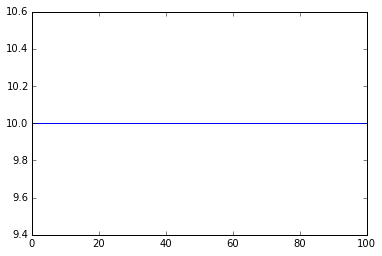

In [12]:
plt.plot(xx)

## Mean and covariance matrix
$\tilde{x}_t = A\tilde{x}_{t-1}+B\left (u_{t-1}+w_{t-1} \right) \\
\tilde{x}_t = A \left (A\tilde{x}_{t-2}+B\left (u_{t-2}+w_{t-2} \right)\right) + B\left (u_{t-1}+w_{t-1} \right) \\
...\\
\tilde{x}_t = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}B \left (u_i+w_i \right)}
$
  
We deduce the mean:
$E\left [\tilde{x}_t \right] = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}Bu_i}$ since $E\left [w_t \right] = 0$.


Then, $cov\left [\tilde{x}_t\right ] = \sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T E\left [w_t^2 \right]} = k\sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T u_t^2}$


  
## Minimum-variance problem
Here, the problem we consider consists in minimizing the sum of the variance of the position after reaching the target. Let $V_t$ be the top-left value in the covariance matrix at time $t$. Then, we want to minimize $\sum \limits_{t=T+1}^{T+R}V_t +bias$. 

In [13]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    A_pow_array = np.zeros((T+R+1,n,n))

    for i in np.arange(T+R+1):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

ci1_array = np.zeros(T+R+1)

for i in np.arange(T+R+1):
    ci1_array[i] = (pow_fast(i).dot(B))[1]
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2]
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3]

ci = np.array([ci0_array, ci1_array])#, ci2_array])

In [15]:
def expectation(u, t):
    """Computation of the expectation of the state vector at time t, given u
    """
    if t == 0:
        return x0
    else:
        return pow_fast(t).dot(x0)+(ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)

In [16]:
mult_v = np.array([1, 1]) # we select the level of each parameter in the cost function
#mult_v2 = np.array([1, .0001])

In [17]:
def variance(u, t):
    """Computation of the variance of the state vector at time t, given u
    """
    return k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()#*mult_v2[0]+k*(np.flipud(ci1_array[0:t]**2)*u[0:t]**2).sum()*mult_v2[1]

In [18]:
def bias(u, t):
    """Computation of the bias of the state vector at time t, given u
    """
    return (((expectation(u, t)-(xT_f(t)))**2)*mult_v).sum()

 
This can be formulated as a quadratic programming problem, which we solved using a gradient descent.

## Gradient descent

Let $\mathscr{C}$ be the cost function to minimize.  
That is, we want to find $\textbf{u}_{\textbf{opt}} = \underset{u_0, ..., u_{T+R}}{argmin} \left (\sum \limits_{t=T+1}^{T+R}V_t  + \sum \limits_{t=T}^{T+R}\|E\left [\tilde{x}_t\right] - x_T \|^2 \right )= \underset{u_0, ..., u_{T+R}}{argmin}\left(\mathscr{C}\left (\textbf{u}\right)\right)$.



In [19]:
def cost(u):
    def var1d(t):
        return(variance(u,t))
    var_vec = np.vectorize(var1d)
    def bias1d(t):
        return(bias(u,t))
    bias_vec = np.vectorize(bias1d)
    return var_vec(T+1+np.arange(R)).sum() + bias_vec(T+np.arange(R+1)).sum()

Iterating the following process, we will get the right $\textbf{u}_{\textbf{opt}}$ :  
$\forall i \in \left \{ 0, ..., T+R-1 \right \} : u_i = u_i - \eta \times \frac{\partial \mathscr{C}\left(\textbf{u}\right)}{\partial u_i}$

In [20]:
def cost_deriv(u, i):
    """Derivative of the cost function with respect to u_i
    """
    if i < T:
        return (2*np.transpose(ci[:,(T-i-1):(T+R-i)])*np.array([((expectation(u,t)-xT_f(t))*mult_v).tolist() for t in (T+np.arange(R+1))])).sum() + 2*k*u[i]*(ci0_array[(T+1-i-1):(T+R-i)]**2).sum()
    else:
        return (2*np.transpose(ci[:,0:(T+R-i)])*np.array([((expectation(u,t)-xT_f(t))*mult_v).tolist() for t in (i+1+np.arange(R+T-i))])).sum() + 2*k*u[i]*(ci0_array[0:(T+R-i)]**2).sum()

In [21]:
niter = 5000
eta = 3000

In [22]:
import time

In [23]:
ubang = np.zeros(T+R+1)

In [24]:
debut = time.time()

u = ubang.copy()
a = np.zeros((niter+1, T+R+1)) # To save the evolution of the values of u at each iteration
a[0, :] = u.copy()
for i_iter in np.arange(niter):
    u_old = u.copy()
    u[0:T+R] = u_old[0:T+R] - eta*np.array([cost_deriv(u_old, i) for i in np.arange(T+R)])
    a[i_iter+1, :] = u.copy()
fin = time.time()

In [25]:
(fin-debut)

423.2965884208679

Then, we draw $\text{u}$, that is, the evolution of the control signal during the experiment.

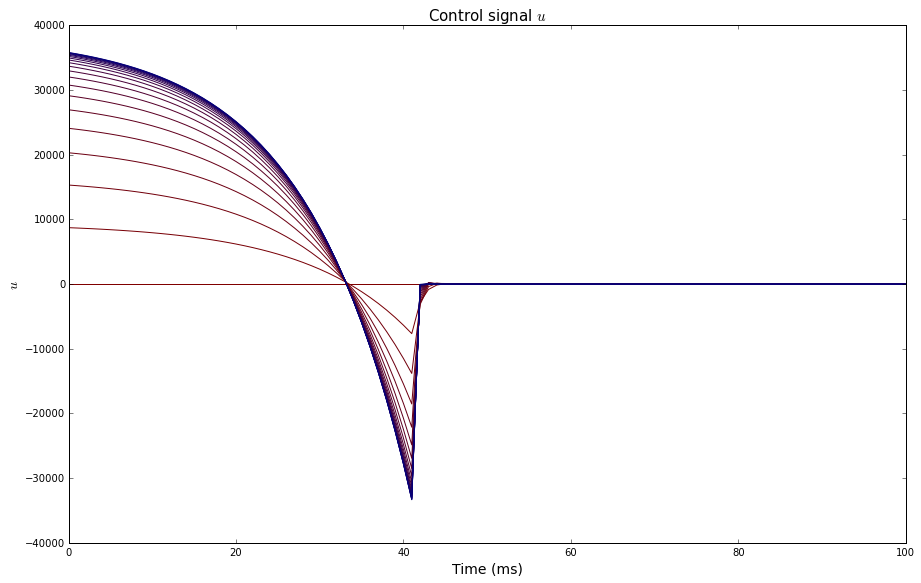

In [26]:
plot_signal(a, 250, 5000, t_T, t_R, 0.001)

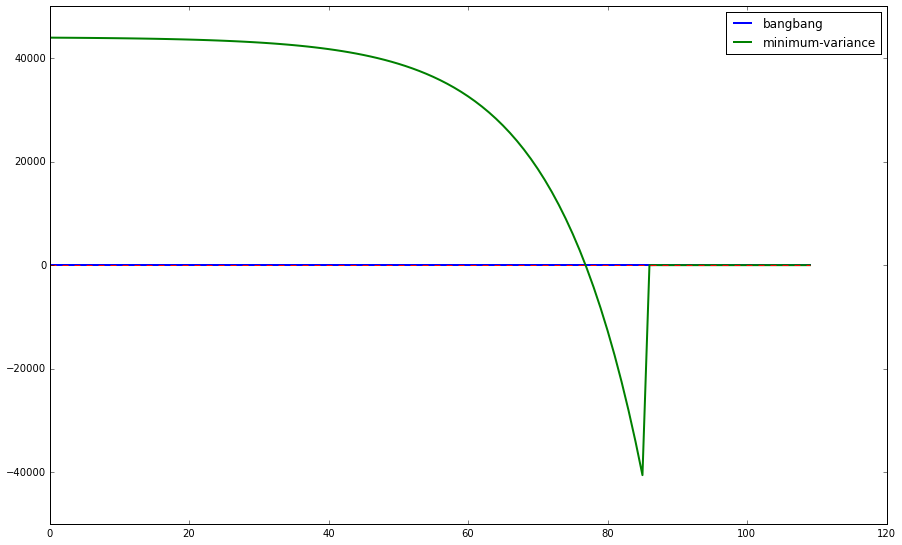

In [334]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, a[0], lw=2, label="bangbang")
ax.plot(time_ms, a[niter], lw=2, label="minimum-variance")
ax.plot([0,(t_T+t_R)*1000],[0,0],'r--')
ax.legend()

In [27]:
position = np.zeros((niter+1,T+R+1))
velocity = np.zeros((niter+1,T+R+1))

for i in np.arange(niter+1):
    for j in np.arange(T+R+1):
        mean = expectation(a[i,:], j)
        position[i,j] = mean[0]
        velocity[i,j] = mean[1]

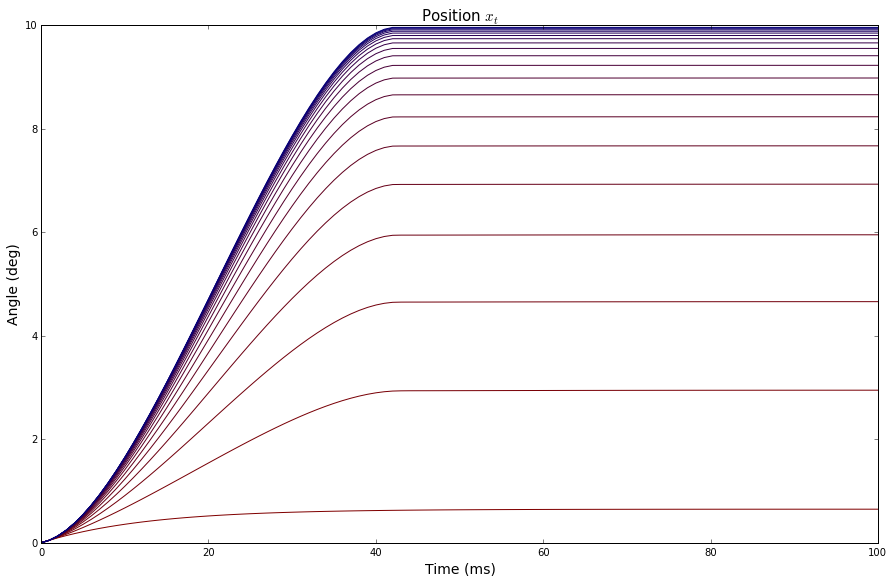

In [28]:
plot_position(position, 250, 5000, t_T, t_R, 0.001)
plt.plot(time_ms, xx,'r--')

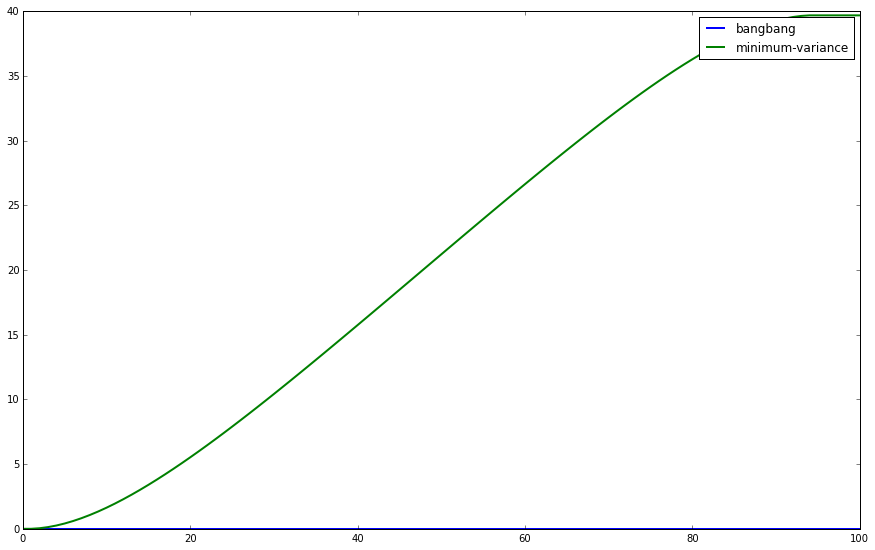

In [390]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, position[0], lw=2, label="bangbang")
ax.plot(time_ms, position[niter], lw=2, label="minimum-variance")
ax.plot(np.linspace(0,(t_T+t_R)*1000,T+R+1), xx,'r--')
ax.legend()


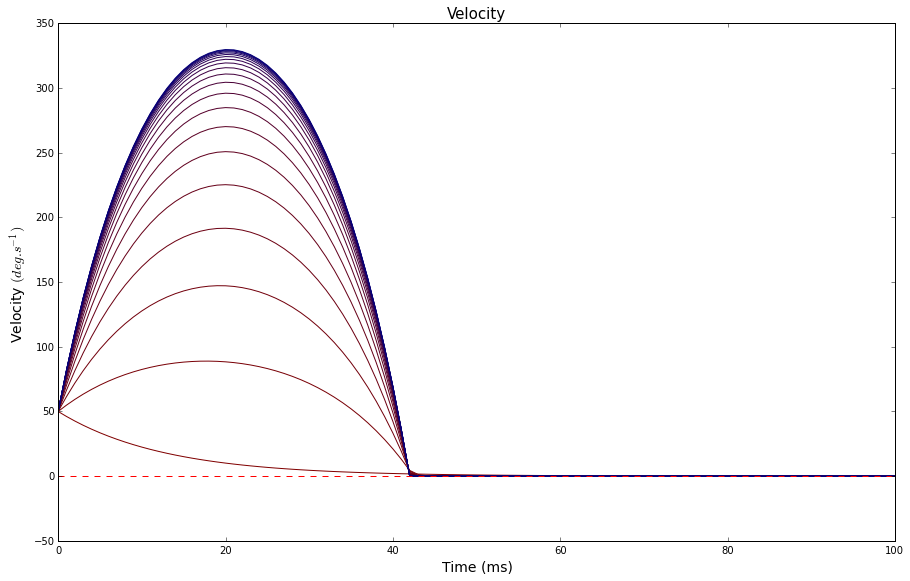

In [29]:
plot_velocity(velocity, 250, 5000, t_T, t_R, 0.001)
plt.plot(time_ms, vv,'r--')

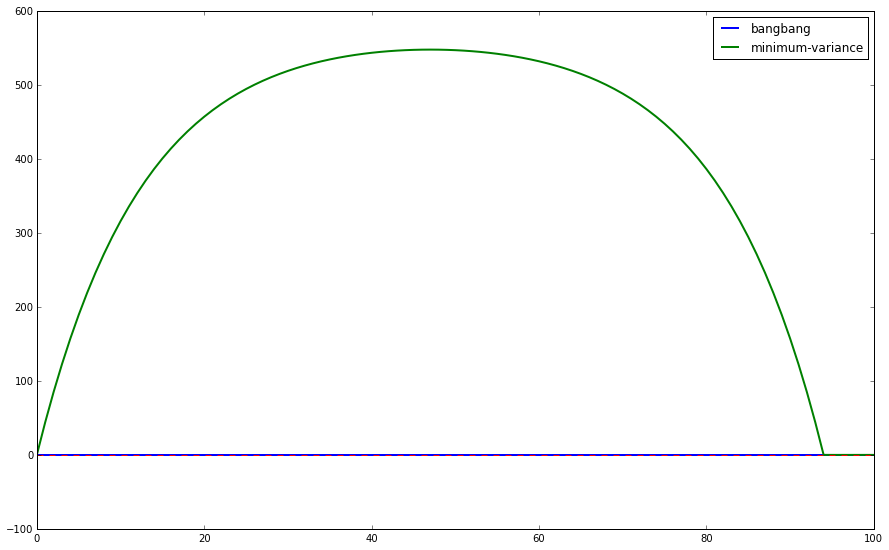

In [392]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, velocity[0], lw=2, label="bangbang")
ax.plot(time_ms, velocity[niter], lw=2, label="minimum-variance")
ax.plot(np.linspace(0,(t_T+t_R)*1000,T+R+1), vv,'r--')
ax.legend()

In [231]:
variancev = np.zeros((niter+1,T+R+1))

for i in np.arange(niter+1):
    for j in np.arange(T+R+1):
        variancev[i,j] = variance(a[i,:], j)

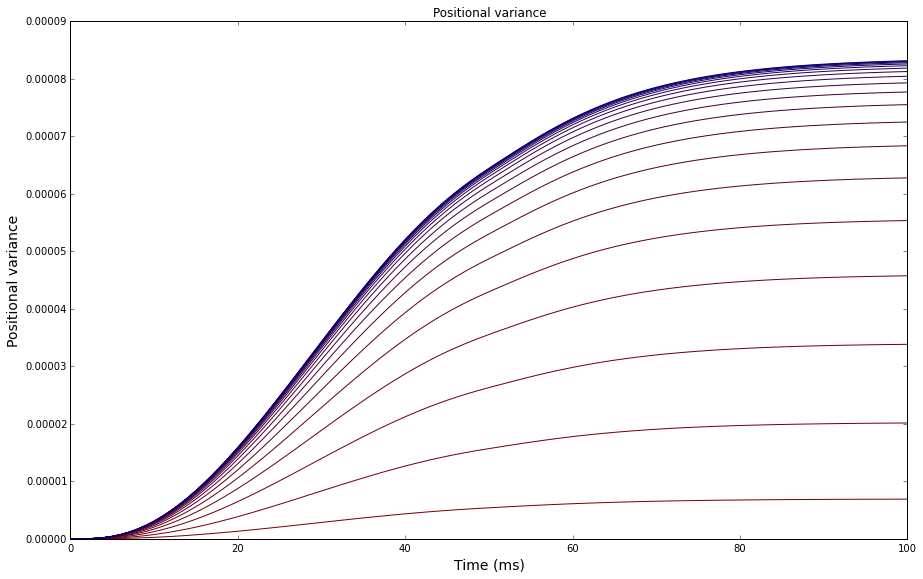

In [232]:
plot_variance(variancev, 250, 5000, t_T, t_R, 0.001)

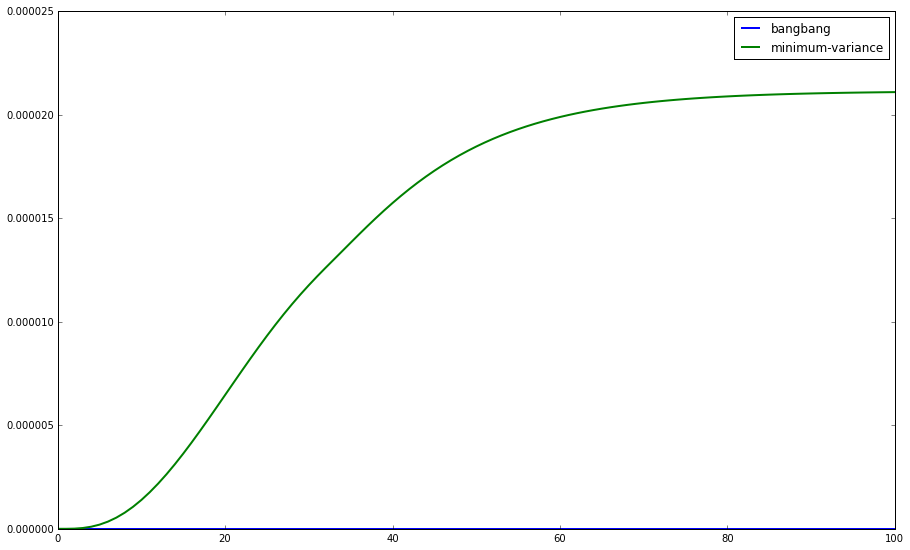

In [175]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
ax.plot(time_ms, variancev[0], lw=2, label="bangbang")
ax.plot(time_ms, variancev[niter], lw=2, label="minimum-variance")
ax.legend()

In [176]:
vel = np.zeros((8,T+R+1))

In [180]:
pos = np.zeros((8,T+R+1))

In [497]:
vel[7,:] = velocity[niter]

In [499]:
pos[7,:] = position[niter]

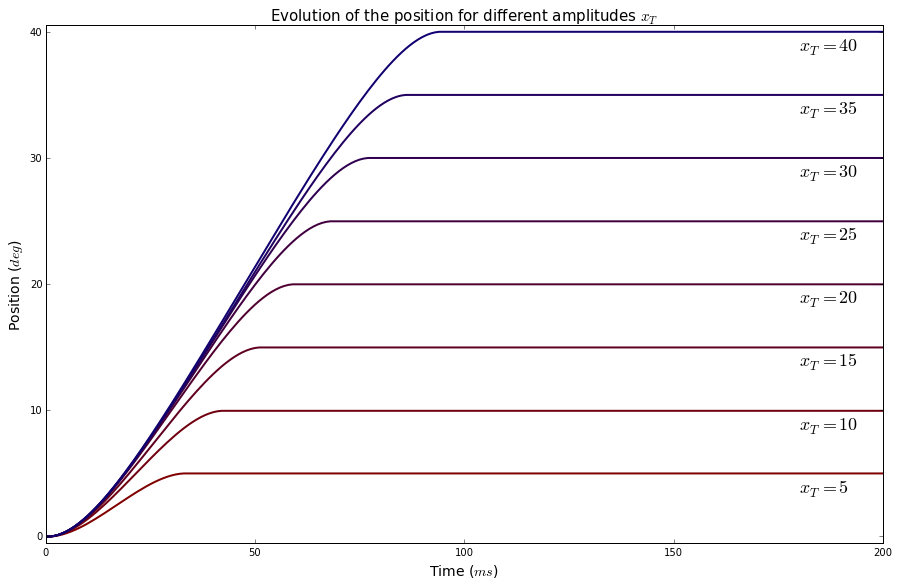

In [538]:
col = np.zeros((8,3))
for i in np.arange(8):
    col[i] = (8-i)/(2*8),0,i/(2*8)

fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((pos[0,:],np.ones(100)*pos[0,T+R])), color = col[0], lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((pos[1,:],np.ones(100)*pos[1,T+R])), color = col[1], lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((pos[2,:],np.ones(100)*pos[2,T+R])), color = col[2], lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((pos[3,:],np.ones(100)*pos[3,T+R])), color = col[3], lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((pos[4,:],np.ones(100)*pos[4,T+R])), color = col[4], lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((pos[5,:],np.ones(100)*pos[5,T+R])), color = col[5], lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((pos[6,:],np.ones(100)*pos[6,T+R])), color = col[6], lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((pos[7,:],np.ones(100)*pos[7,T+R])), color = col[7], lw = 2)
#ax.plot(np.linspace(0,2*(t_T+t_R)*1000,2*T+2*R+1), np.ones(2*T+2*R+1)*target[0],'r--')
#ax.plot(np.linspace(0,2*(t_T+t_R)*1000,2*T+2*R+1), np.ones(2*T+2*R+1)*target[1],'r--')
#ax.plot(np.linspace(0,2*(t_T+t_R)*1000,2*T+2*R+1), np.ones(2*T+2*R+1)*target[2],'r--')
#ax.plot(np.linspace(0,2*(t_T+t_R)*1000,2*T+2*R+1), np.ones(2*T+2*R+1)*target[3],'r--')
#ax.plot(np.linspace(0,2*(t_T+t_R)*1000,2*T+2*R+1), np.ones(2*T+2*R+1)*target[4],'r--')
#ax.plot(np.linspace(0,2*(t_T+t_R)*1000,2*T+2*R+1), np.ones(2*T+2*R+1)*target[5],'r--')
#ax.plot(np.linspace(0,2*(t_T+t_R)*1000,2*T+2*R+1), np.ones(2*T+2*R+1)*target[6],'r--')
#ax.plot(np.linspace(0,2*(t_T+t_R)*1000,2*T+2*R+1), np.ones(2*T+2*R+1)*target[7],'r--')
plt.text(180, 3.5, r'$x_T = 5$', fontsize = 18)
plt.text(180, 8.5, r'$x_T = 10$', fontsize = 18)
plt.text(180, 13.5, r'$x_T = 15$', fontsize = 18)
plt.text(180, 18.5, r'$x_T = 20$', fontsize = 18)
plt.text(180, 23.5, r'$x_T = 25$', fontsize = 18)
plt.text(180, 28.5, r'$x_T = 30$', fontsize = 18)
plt.text(180, 33.5, r'$x_T = 35$', fontsize = 18)
plt.text(180, 38.5, r'$x_T = 40$', fontsize = 18)


ax.set_ylim(-0.5, target[7]+0.5)

ax.set_title(r'Evolution of the position for different amplitudes $x_T$', fontsize = 15)
ax.set_xlabel('Time ($ms$)', fontsize=14)
ax.set_ylabel(r'Position ($deg$)', fontsize=14)

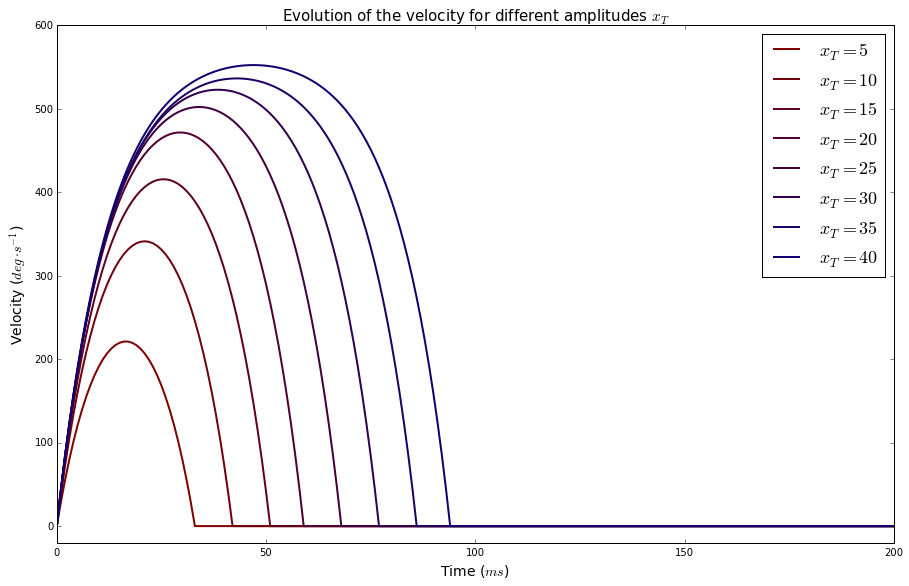

In [549]:
col = np.zeros((8,3))
for i in np.arange(8):
    col[i] = (8-i)/(2*8),0,i/(2*8)

fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((vel[0,:],np.zeros(100))), color = col[0], label= r'$x_T = 5$', lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((vel[1,:],np.zeros(100))), color = col[1], label= r'$x_T = 10$', lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((vel[2,:],np.zeros(100))), color = col[2], label= r'$x_T = 15$', lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((vel[3,:],np.zeros(100))), color = col[3], label= r'$x_T = 20$', lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((vel[4,:],np.zeros(100))), color = col[4], label= r'$x_T = 25$', lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((vel[5,:],np.zeros(100))), color = col[5], label= r'$x_T = 30$', lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((vel[6,:],np.zeros(100))), color = col[6], label= r'$x_T = 35$', lw = 2)
plt.plot(np.linspace(0,200,2*T+2*R+1), np.concatenate((vel[7,:],np.zeros(100))), color = col[7], label= r'$x_T = 40$', lw = 2)

ax.legend(prop={'size':18})


ax.set_ylim(-20, 600)

ax.set_title(r'Evolution of the velocity for different amplitudes $x_T$', fontsize = 15)
ax.set_xlabel('Time ($ms$)', fontsize=14)
ax.set_ylabel(r'Velocity ($deg\cdot s^{-1}$)', fontsize=14)

In [506]:
peak_vel = np.array([max(vel[0]),max(vel[1]),max(vel[2]),max(vel[3]),max(vel[4]),max(vel[5]),max(vel[6]),max(vel[7])])

In [504]:
alpha = (np.sqrt(np.concatenate((np.zeros(1),target)))*np.concatenate((np.zeros(1),peak_vel))).sum()/((np.concatenate((np.zeros(1),target))).sum())

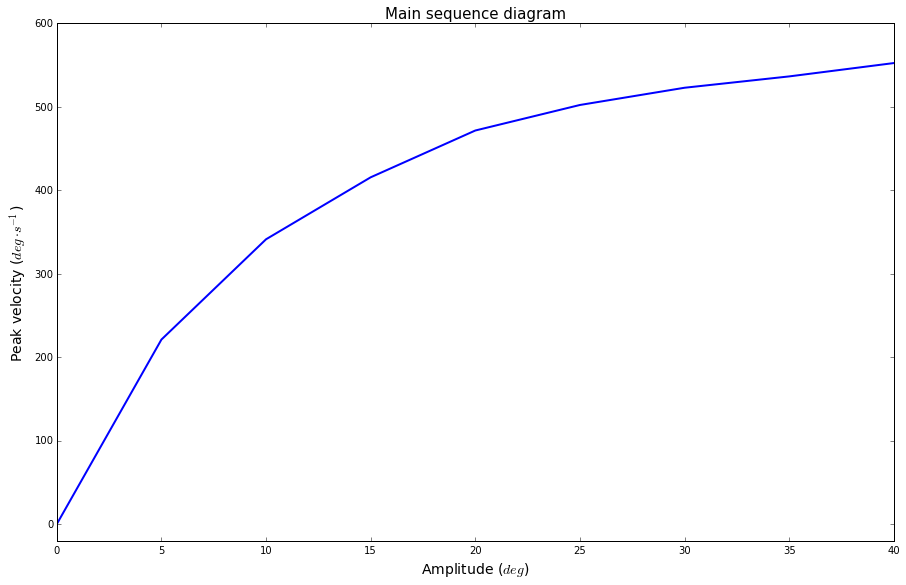

In [548]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
plt.plot(np.concatenate((np.zeros(1),target)), np.concatenate((np.zeros(1),peak_vel)),lw = 2)
ax.set_ylim(-20, 600)

ax.set_title('Main sequence diagram', fontsize = 15)
ax.set_xlabel('Amplitude ($deg$)', fontsize=14)
ax.set_ylabel(r'Peak velocity ($deg\cdot s^{-1}$)', fontsize=14)

In [505]:
alpha

96.327554358355016

In [56]:
cost_p = np.zeros(niter+1)

for i in np.arange(niter+1):
    cost_p[i] = cost(a[i])

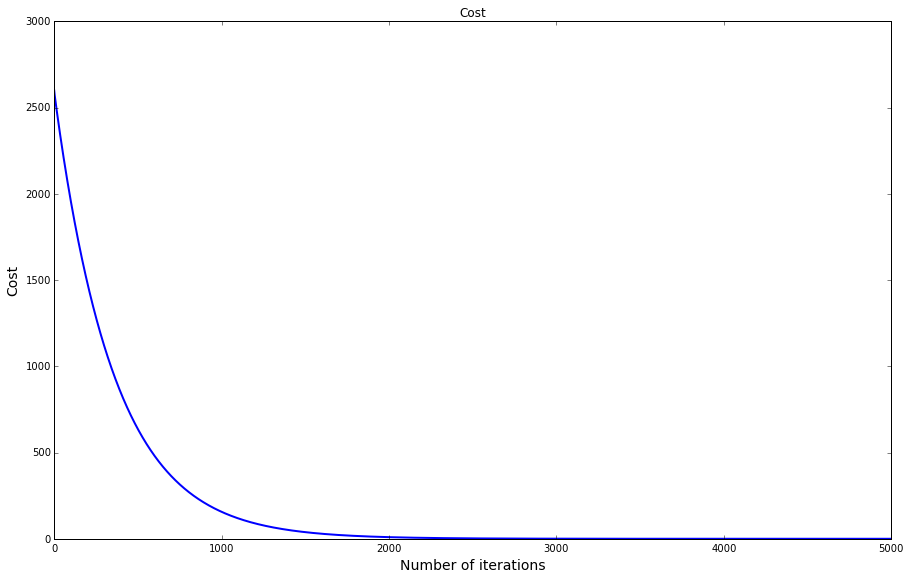

In [57]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(cost_p, '-', lw = 2)
ax.set_title('Cost')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Cost', fontsize=14)


Finally, we trace the position at time T for each iteration.

In [58]:
positionT = np.zeros(niter+1)

for i in np.arange(niter+1):
    positionT[i] = (expectation(a[i], T))[0]

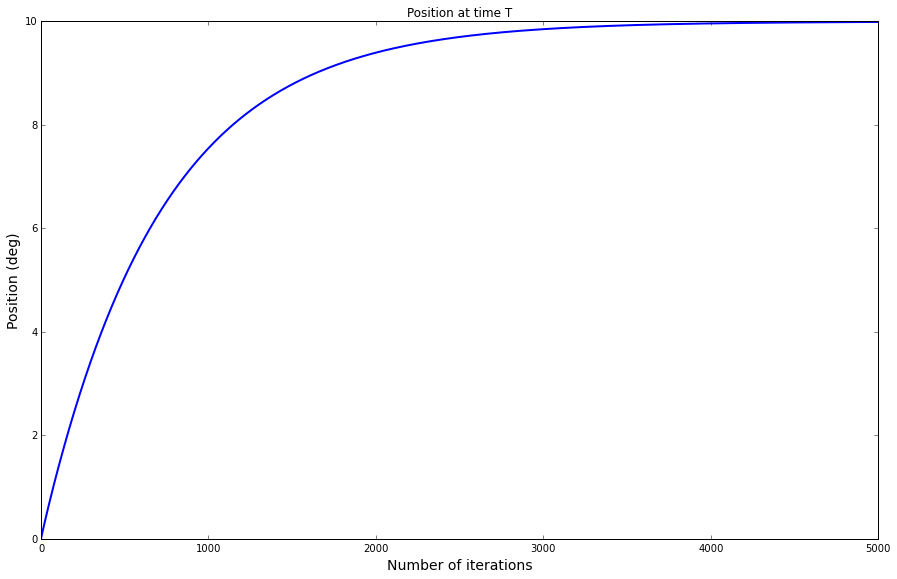

In [59]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))

ax.plot(positionT, '-', lw=2)
ax.set_title('Position at time T')
ax.set_xlabel('Number of iterations', fontsize=14)
ax.set_ylabel('Position (deg)', fontsize=14)
ax.plot([0,niter],[xT[0]+v*t_T ,xT[0]+v*t_T],'r--')


In [550]:
import pickle
import pandas as pd
record = pd.DataFrame()
for i in np.arange(8):
    record_one = pd.DataFrame([{'position':pos[i,:],'velocity':vel[i,:]}],index=[i])
    record = pd.concat([record, record_one])
record.to_pickle('../2017_OptimalPrecision/DataRecording/'+'HarrisWolpertPursuit_dt=0.001_tau=0.013_data_for_main_sequence.pkl')

In [552]:
import pickle
import pandas as pd
record = pd.read_pickle('/home/baptiste/Documents/2017_OptimalPrecision/DataRecording/'+'HarrisWolpertPursuit_dt=0.002_beta=100_m=1_cosinus'+'.pkl')

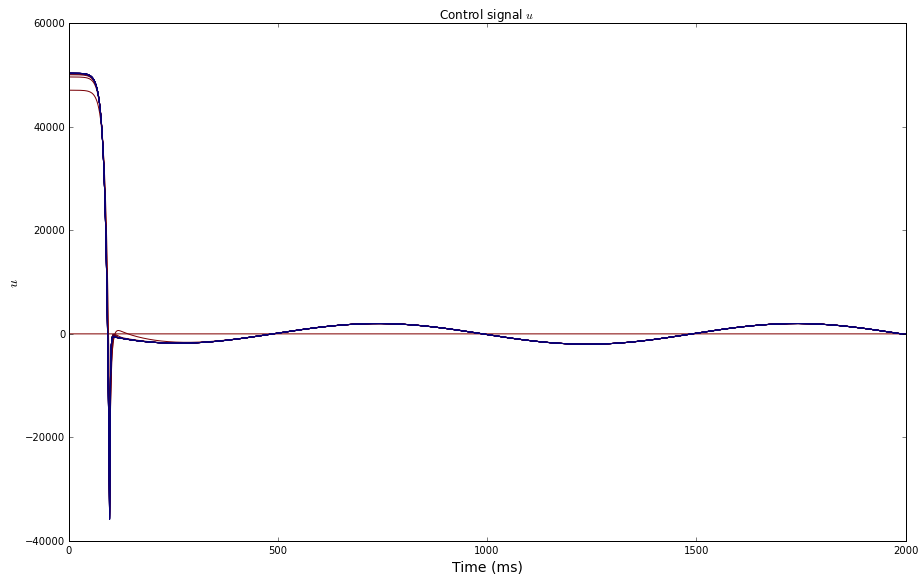

In [558]:
plot_signal(record.signal, 500, 10000, 0.1, 1.9, 0.002)

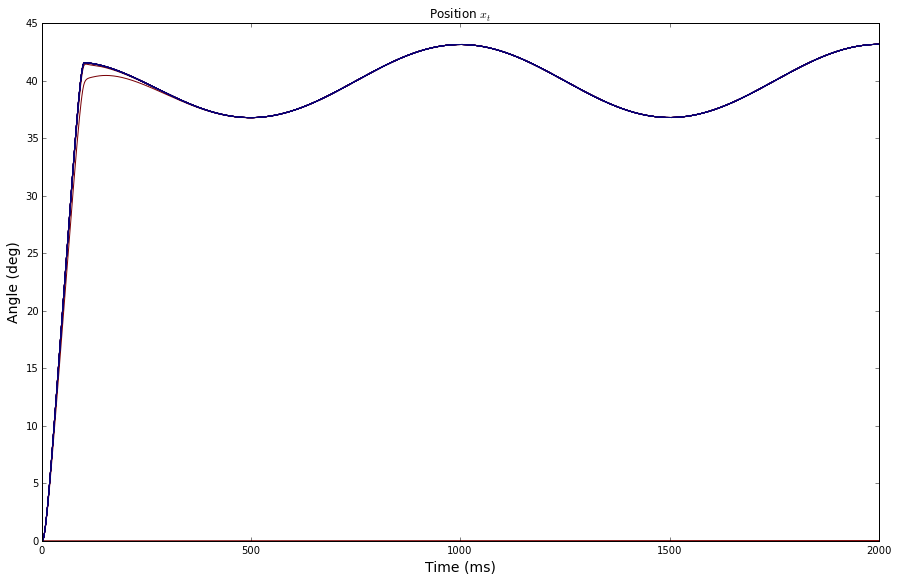

In [561]:
plot_position(record.position, 500, 10000, 0.1, 1.9, 0.002)


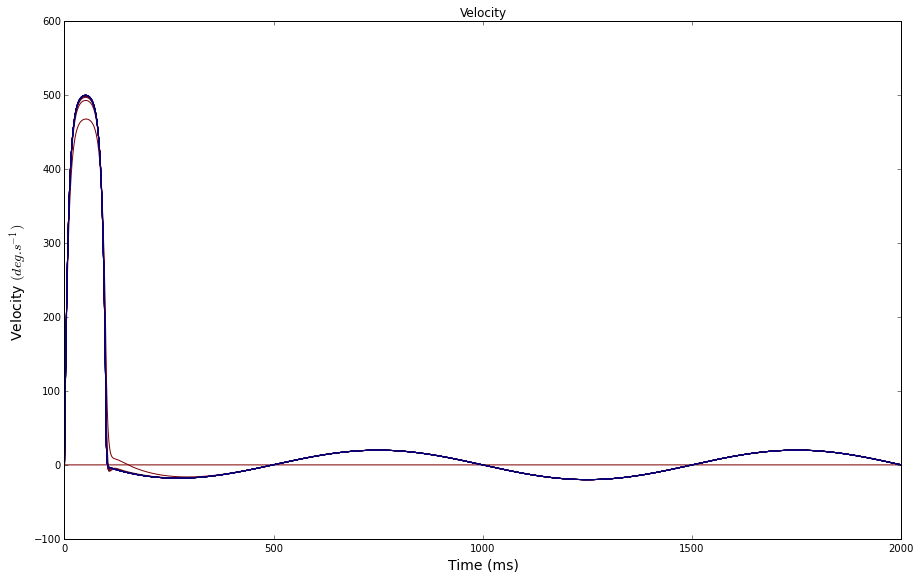

In [562]:
plot_velocity(record.velocity, 500, 10000, 0.1, 1.9, 0.002)
